# Twitter Disaster Prediction

### Import Libraries

In [33]:
import pandas as pd
import numpy as np

from sklearn import linear_model, model_selection, preprocessing, metrics, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import string
# nltk.download('stopwords')
# nltk.download('punkt')

import matplotlib.pyplot as plt
from plotnine import *

# tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub


### Read Data

In [2]:
# read data
train = pd.read_csv( '../data/nlp-getting-started/train.csv' )
test  = pd.read_csv( '../data/nlp-getting-started/test.csv' )
subm_samp = pd.read_csv( '../data/nlp-getting-started/sample_submission.csv' )

train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
##
## Checking size of each class on train set
print( ' Class 1 Size : ' + str(train[ train['target'] == 1 ].shape[0]) )
print( ' Class 0 Size : ' + str(train[ train['target'] == 0 ].shape[0]) )

 Class 1 Size : 3271
 Class 0 Size : 4342


### Split Train / Test Set

In [6]:
# Split the dataset for cross validation
X_train, X_test, y_train, y_test = train_test_split(train.text, 
                                                    train.target, 
                                                    test_size=0.25, 
                                                    random_state=123)


print('Train shape:' + str(X_train.shape) )
print('Proportion of class 0 in train: ' + str( np.round( 100*np.sum(y_train==0) / len(y_train), 2 ) ) + '%' )
print('Proportion of class 1 in train: ' + str( np.round( 100*np.sum(y_train==1) / len(y_train), 2 ) ) + '%' )
print('')
print('Test shape:' + str(X_test.shape) )
print('Proportion of class 0 in train: ' + str( np.round( 100*np.sum(y_test==0) / len(y_test), 2 ) ) + '%' )
print('Proportion of class 1 in train: ' + str( np.round( 100*np.sum(y_test==1) / len(y_test), 2 ) ) + '%' )

Train shape:(5709,)
Proportion of class 0 in train: 56.84%
Proportion of class 1 in train: 43.16%

Test shape:(1904,)
Proportion of class 0 in train: 57.62%
Proportion of class 1 in train: 42.38%


## Feature Engineering

### Universal Sentence Encoder

The module does not require preprocessing the data before applying the module, it performs best effort text input preprocessing inside the graph.

In [5]:
import tensorflow as tf
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## Models

In [8]:
# Create embedding based on clean version of text
X_train_embed = embed( X_train )
X_test_embed  = embed( X_test )

### Ridge Classifier

In [13]:
print('')
print('Ridge Classifier')
print('')

from sklearn.linear_model import RidgeClassifierCV
clf_ridge = RidgeClassifierCV( alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10], cv = 5 ).fit(X_train_embed, y_train)

# clf_ridge.get_params()

print( 'Train 0/1 Accuracy: ' + str( np.mean( clf_ridge.predict(X_train_embed) == y_train ) ) )
print( 'Test 0/1 Accuracy: ' + str( np.mean( clf_ridge.predict(X_test_embed) == y_test ) ) )
print('')
print( 'Train F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_train.to_numpy(), (-1, 1)),
                                                   y_pred = clf_ridge.predict(X_train_embed) ) ) )
print( 'Test F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_test.to_numpy(), (-1, 1)),
                                                  y_pred = clf_ridge.predict(X_test_embed) ) ) )


Ridge Classifier

Train 0/1 Accuracy: 0.8320196181467858
Test 0/1 Accuracy: 0.8109243697478992

Train F1 Score: 0.7962608880390907
Test F1 Score: 0.7650130548302871


### Bernoulli Naive Bayes

In [14]:
##
## Fit Bernoulli Naive-Bayes
print('')
print('Bernoulli Naive Bayes')
print('')

clf_nb = BernoulliNB().fit( X_train_embed, y_train )
clf_nb

##
## Predict on train / test set
print( 'Train 0/1 Accuracy: ' + str( np.mean( clf_nb.predict(X_train_embed) == y_train ) ) )
print( 'Test 0/1 Accuracy: ' + str( np.mean( clf_nb.predict(X_test_embed) == y_test ) ) )
print('')
print( 'Train F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_train.to_numpy(), (-1, 1)),
                                                   y_pred = clf_nb.predict(X_train_embed) ) ) )
print( 'Test F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_test.to_numpy(), (-1, 1)),
                                                  y_pred = clf_nb.predict(X_test_embed) ) ) )


Bernoulli Naive Bayes

Train 0/1 Accuracy: 0.78857943597828
Test 0/1 Accuracy: 0.7699579831932774

Train F1 Score: 0.7539245667686034
Test F1 Score: 0.725219573400251


### PCA + Ridge Classifier

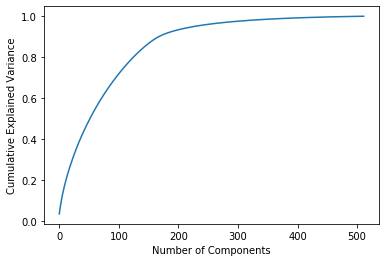

In [42]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_embed)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [46]:
##
## Select number of components and transform original data (embedded)
n_pca_comps = 180
X_train_embed_pca = PCA( n_components = n_pca_comps ).fit_transform( X_train_embed )
X_test_embed_pca  = PCA( n_components = n_pca_comps ).fit_transform( X_test_embed )

In [48]:
print('')
print('PCA + Ridge Classifier')
print('')

clf_ridge = RidgeClassifierCV( alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10], cv = 5 ).fit(X_train_embed_pca, y_train)

# clf_ridge.get_params()

print( 'Train 0/1 Accuracy: ' + str( np.mean( clf_ridge.predict(X_train_embed_pca) == y_train ) ) )
print( 'Test 0/1 Accuracy: ' + str( np.mean( clf_ridge.predict(X_test_embed_pca) == y_test ) ) )
print('')
print( 'Train F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_train.to_numpy(), (-1, 1)),
                                                   y_pred = clf_ridge.predict(X_train_embed_pca) ) ) )
print( 'Test F1 Score: ' + str( metrics.f1_score( y_true = np.reshape(y_test.to_numpy(), (-1, 1)),
                                                  y_pred = clf_ridge.predict(X_test_embed_pca) ) ) )


PCA + Ridge Classifier

Train 0/1 Accuracy: 0.8302679978980557
Test 0/1 Accuracy: 0.7720588235294118

Train F1 Score: 0.7942238267148013
Test F1 Score: 0.7290886392009988


### Feed-forward Neural Network

In [87]:

##
## Define model's architecture
model = tf.keras.Sequential()
model.add( tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_embed.shape[1],) ) )
model.add( tf.keras.layers.Dense(12, activation='relu', input_shape=(X_train_embed.shape[1],) ) )
model.add( tf.keras.layers.Dropout(0.25, seed=123) )
model.add( tf.keras.layers.Dense(1, activation='sigmoid' ) )

##
## Compile model
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

##
## Print model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                8208      
_________________________________________________________________
dense_29 (Dense)             (None, 12)                204       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 13        
Total params: 8,425
Trainable params: 8,425
Non-trainable params: 0
_________________________________________________________________


In [88]:
## Train Model
model.fit(X_train_embed,
          y_train,
          epochs=20,
          validation_data=(X_test_embed, y_test),
          verbose=1 )

Train on 5709 samples, validate on 1904 samples
Epoch 1/20
5709/5709 [==============================] - 1s 128us/sample - loss: 0.5749 - accuracy: 0.7528 - val_loss: 0.4750 - val_accuracy: 0.7988
Epoch 2/20
5709/5709 [==============================] - 0s 43us/sample - loss: 0.4512 - accuracy: 0.8073 - val_loss: 0.4352 - val_accuracy: 0.8104
Epoch 3/20
5709/5709 [==============================] - 0s 43us/sample - loss: 0.4242 - accuracy: 0.8131 - val_loss: 0.4288 - val_accuracy: 0.8109
Epoch 4/20
5709/5709 [==============================] - 0s 43us/sample - loss: 0.4139 - accuracy: 0.8208 - val_loss: 0.4261 - val_accuracy: 0.8136
Epoch 5/20
5709/5709 [==============================] - 0s 43us/sample - loss: 0.4094 - accuracy: 0.8273 - val_loss: 0.4235 - val_accuracy: 0.8120
Epoch 6/20
5709/5709 [==============================] - 0s 44us/sample - loss: 0.3999 - accuracy: 0.8289 - val_loss: 0.4259 - val_accuracy: 0.8088
Epoch 7/20
5709/5709 [==============================] - 0s 43us/sampl

In [89]:
##
## Predict on train / test set
print('')
print('Neural Net - Fully Connected')
print('')

# get predictions for in/out of sample
preds_train = np.reshape( np.round(model.predict(X_train_embed)), (-1,) )
preds_test  = np.reshape( np.round(model.predict(X_test_embed)), (-1,) )

print( 'Train 0/1 Accuracy: ' + str( np.mean( preds_train == y_train ) ) )
print( 'Test 0/1 Accuracy: ' + str( np.mean( preds_test == y_test ) ) )
print('')
print( 'Train F1 Score: ' + str( metrics.f1_score( y_true = y_train,
                                                   y_pred = preds_train ) ) )
print( 'Test F1 Score: ' + str( metrics.f1_score( y_true = y_test,
                                                   y_pred = preds_test ) ) )


Neural Net - Fully Connected

Train 0/1 Accuracy: 0.8924505167279734
Test 0/1 Accuracy: 0.8188025210084033

Train F1 Score: 0.8643393725143614
Test F1 Score: 0.7648261758691206


## Generate submission for Kaggle competition

Fit model on all training data then generate predictions on supplied test data

In [90]:
model = tf.keras.Sequential()
model.add( tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_embed.shape[1],) ) )
model.add( tf.keras.layers.Dense(12, activation='relu', input_shape=(X_train_embed.shape[1],) ) )
model.add( tf.keras.layers.Dropout(0.25, seed=123) )
model.add( tf.keras.layers.Dense(1, activation='sigmoid' ) )

##
## Compile model
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

##
## Fit
model.fit(embed( train.text ),
          train.target,
          epochs=20,
          validation_split = 0,
          verbose=1 )

Train on 7613 samples
Epoch 1/20
7613/7613 [==============================] - 1s 94us/sample - loss: 0.5390 - accuracy: 0.7644
Epoch 2/20
7613/7613 [==============================] - 0s 36us/sample - loss: 0.4423 - accuracy: 0.8056
Epoch 3/20
7613/7613 [==============================] - 0s 36us/sample - loss: 0.4243 - accuracy: 0.8124
Epoch 4/20
7613/7613 [==============================] - 0s 36us/sample - loss: 0.4185 - accuracy: 0.8206
Epoch 5/20
7613/7613 [==============================] - 0s 36us/sample - loss: 0.4097 - accuracy: 0.8277
Epoch 6/20
7613/7613 [==============================] - 0s 38us/sample - loss: 0.4049 - accuracy: 0.8274
Epoch 7/20
7613/7613 [==============================] - 0s 36us/sample - loss: 0.3984 - accuracy: 0.8332
Epoch 8/20
7613/7613 [==============================] - 0s 35us/sample - loss: 0.3900 - accuracy: 0.8354
Epoch 9/20
7613/7613 [==============================] - 0s 41us/sample - loss: 0.3876 - accuracy: 0.8386
Epoch 10/20
7613/7613 [==========

In [92]:
submission_embed = embed( test.text )
submission_preds = np.reshape( np.round(model.predict(submission_embed)), (-1,) )

test['target'] = submission_preds
test.target = test.target.astype(int)
test[['id','target']]
test[['id','target']].to_csv( '../data/submissions/submission_20200501_v2.csv', index = False )